In [337]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.0.dev2151-g2a716
Compiled: Dec 23 2014 21:10:53



64-bit float


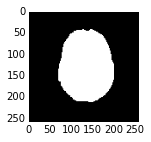

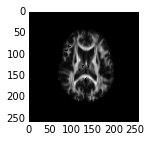

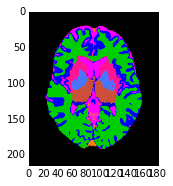

In [338]:
TEST_DIR='/scratch/TESTS/IpythonNotebook/2_PrimaryTestToComputeRISs'

FA_filename='/scratch/TESTS/BS/DWIWorkflow_Nipype/7_repeatTest6InFloat/19568/Outputs/FA.nrrd'
mask_filename = '/scratch/TESTS/BS/DWIWorkflow_Nipype/7_repeatTest6InFloat/19568/Outputs/BrainMaskForDWI.nrrd'
labels_filename = '/Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_024/1155/19568/TissueClassify/complete_brainlabels_seg.nii.gz'

FA = sitk.ReadImage(FA_filename)
in_mask = sitk.ReadImage(mask_filename)
labels = sitk.ReadImage(labels_filename)

myshow(in_mask)
myshow(FA)
myshow(sitk.LabelToRGB(labels))

print(FA.GetPixelIDTypeAsString())

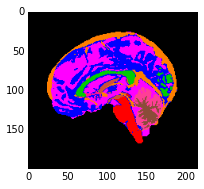

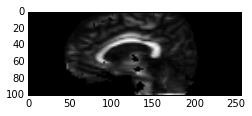

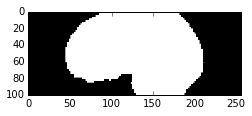

In [339]:
size=labels.GetSize()
myshow(sitk.LabelToRGB(labels[size[0]//2,:,::-1]))
size=FA.GetSize()
myshow(sitk.Expand(FA[size[0]//2,:,:],[5,5,5]))
size=in_mask.GetSize()
myshow(sitk.Expand(in_mask[size[0]//2,:,:],[5,5,5]))

In [340]:
#1# Dilate the input mask
dilateFilter = sitk.BinaryDilateImageFilter()
dilateFilter.SetKernelRadius(1)
dilated_mask = dilateFilter.Execute( in_mask )
dilated_mask_fn = os.path.join(TEST_DIR,'dilated_mask.nrrd')
sitk.WriteImage(dilated_mask,dilated_mask_fn)

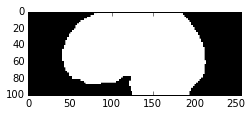

In [341]:
size=dilated_mask.GetSize()
myshow(sitk.Expand(dilated_mask[size[0]//2,:,:],[5,5,5]))

8-bit unsigned integer


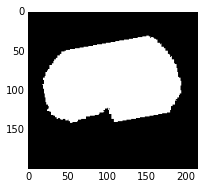

In [342]:
#2# Resample the dilated binary mask to 1x1x1
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(labels)
#resFilt.SetOutputPixelType(dilated_mask.GetPixelIDValue())
resFilt.SetOutputPixelType(sitk.sitkFloat32)
resFilt.SetInterpolator(sitk.sitkLinear)
dilated_mask_res = resFilt.Execute(dilated_mask)

threshFilt = sitk.BinaryThresholdImageFilter()
dilated_mask_res = threshFilt.Execute(dilated_mask_res,0.0001,1.0,1,0)
#dilated_mask_res = dilated_mask_res > 0.5

size=dilated_mask_res.GetSize()
myshow(dilated_mask_res[size[0]//2,:,::-1])
print (dilated_mask_res.GetPixelIDTypeAsString ())

In [343]:
dilated_mask_res_fn = os.path.join(TEST_DIR,'dilated_mask_resampled.nrrd')
sitk.WriteImage(dilated_mask_res,dilated_mask_res_fn)

In [346]:
print(dilated_mask_res.GetPixelIDTypeAsString())
print(labels.GetPixelIDTypeAsString())
    
#3# Multiply the binary mask to the label map
masked_labels = dilated_mask_res * labels

8-bit unsigned integer
8-bit unsigned integer


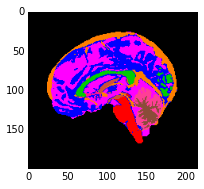

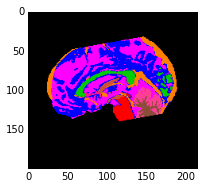

In [345]:
size=labels.GetSize()
myshow(sitk.LabelToRGB(labels[size[0]//2,:,::-1]))
size=masked_labels.GetSize()
myshow(sitk.LabelToRGB(masked_labels[size[0]//2,:,::-1]))

In [304]:
masked_labels_fn = os.path.join(TEST_DIR,'masked_labels.nrrd')
sitk.WriteImage(masked_labels,masked_labels_fn)

###### Now we have two label maps. Original and Cropped.

64-bit float


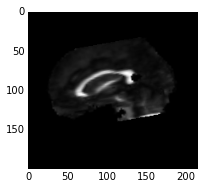

In [305]:
#4# resample the FA to the voxel lattice of the label map (1x1x1)
# Which interpolation? Let's do Linear -> See end of page
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(labels)
resFilt.SetOutputPixelType(FA.GetPixelIDValue())
resFilt.SetInterpolator(sitk.sitkLinear)
FA_res = resFilt.Execute(FA)

FA_res_fn = os.path.join(TEST_DIR,'FA_resampled.nrrd')
sitk.WriteImage(FA_res,FA_res_fn)

size=FA_res.GetSize()
myshow(FA_res[size[0]//2,:,::-1])

print (FA_res.GetPixelIDTypeAsString ())

###### WM -> 1 SURFGM -> 2 CSF -> 4 VB -> 5 CRBLGM -> 11 CRBLWM -> 12 BASAL -> 19 GLOBUS -> 23 THALAMUS -> 24 HIPPOCAMPUS -> 25 AIR -> 0

In [327]:
labelID = 1

In [328]:
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA_res, masked_labels)
print(statFilter.GetNumberOfLabels())
print(statFilter.GetLabels())

12
(0L, 1L, 2L, 4L, 5L, 11L, 12L, 21L, 23L, 24L, 25L, 30L)


In [329]:
print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=FA_res.GetSpacing()[0]*FA_res.GetSpacing()[1]*FA_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

#import operator
#voxelVolume=reduce(operator.mul, FA_res.GetSpacing())
#print(voxelVolume)

mean: 0.272754051794
std: 0.160357859466
max: 0.923522274703
min: 0.0
median: 0.250027231872
Num of voxels: 573275
effective_volume: 573275.0


In [330]:
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA_res, labels)
print(statFilter.GetNumberOfLabels())
print(statFilter.GetLabels())

12
(0L, 1L, 2L, 4L, 5L, 11L, 12L, 21L, 23L, 24L, 25L, 30L)


In [331]:
voxelSize=FA_res.GetSpacing()[0]*FA_res.GetSpacing()[1]*FA_res.GetSpacing()[2]
total_volume=statFilter.GetCount(labelID) * voxelSize
print('mean:',statFilter.GetMean(labelID))
print('total_volume:',total_volume)

mean: 0.271363801938
total_volume: 576212.0


In [332]:
print('confidence_coeficient:',effective_volume/total_volume)

confidence_coeficient: 0.994902917676


# A TEST to decide about best intepolation

In [290]:
####################################################### 
###################### A TEST
####################################################### 
# Here I compute the stats of FA along whole brain in original and resampled space
############ ########### 
# 1) orig space with original input mask
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA, in_mask)
print(statFilter.GetNumberOfLabels())
labelID=1

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=FA.GetSpacing()[0]*FA.GetSpacing()[1]*FA.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
mean: 0.191182998415
std: 0.170586938015
max: 1.20863385947
min: 0.0
median: 0.129833720624
Num of voxels: 167330
effective_volume: 1338640.0


In [351]:
############ ########### 
# Choose an interpolation method
############ ########### 

resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(labels)
resFilt.SetOutputPixelType(FA.GetPixelIDValue())
#resFilt.SetOutputPixelType(sitk.sitkFloat64)
#resFilt.SetInterpolator(sitk.sitkBSpline)
#resFilt.SetInterpolator(sitk.sitkLinear)
resFilt.SetInterpolator(sitk.sitkLabelGaussian)
FA_res = resFilt.Execute(FA)

############ ########### 
# 2) resampled space
whole_mask = masked_labels>0

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA_res, whole_mask)
print(statFilter.GetNumberOfLabels())

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=FA_res.GetSpacing()[0]*FA_res.GetSpacing()[1]*FA_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
mean: 0.17681458324
std: 0.174532353957
max: 0.992041543718
min: 0.0
median: 0.11431728676
Num of voxels: 1309693
effective_volume: 1309693.0


In [352]:
# Now I use run cubic BSpline on sqrt values of image, and squars the output resample image!
# 1-sqrt image
sqrtFilt = sitk.SqrtImageFilter()
FA_sqrt = sqrtFilt.Execute(FA)

# 2-resample image
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(labels)
resFilt.SetInterpolator(sitk.sitkBSpline)
FA_sqrt_res = resFilt.Execute(FA_sqrt)

# 3-square the image
squarFilt = sitk.SquareImageFilter()
FA_res = squarFilt.Execute(FA_sqrt_res)

whole_mask = masked_labels>0

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA_res, whole_mask)
print(statFilter.GetNumberOfLabels())

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=FA_res.GetSpacing()[0]*FA_res.GetSpacing()[1]*FA_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
mean: 0.192835956993
std: 0.168928621005
max: 1.23457905181
min: 2.69733040804e-12
median: 0.132620796561
Num of voxels: 1309693
effective_volume: 1309693.0


# So use 'sqrt+BSpline+square' interpolation because negative value does not have any meaning in RISs

In [292]:
####################################################### 
## Interpolation for label mask
####################################################### 

# orig space with customized input mask
# linear interpolation and Thresholding is used 

label_mask = labels>0
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(FA)
resFilt.SetOutputPixelType(sitk.sitkFloat32)
resFilt.SetInterpolator(sitk.sitkLinear)
label_mask_res_1 = resFilt.Execute(label_mask)

label_mask_res_fn = os.path.join(TEST_DIR,'resampled_in_mask_beforeThresh.nrrd')
sitk.WriteImage(label_mask_res,label_mask_res_fn)

print(label_mask_res_1.GetPixelIDTypeAsString())

#label_mask_res = sitk.sitkFloat64(label_mask_res_1) > sitk.sitkFloat64(0.9)
threshFilt = sitk.BinaryThresholdImageFilter()
label_mask_res = threshFilt.Execute(label_mask_res_1,0.00001,1.0,1,0)

print(label_mask_res.GetPixelIDTypeAsString())

label_mask_res_fn = os.path.join(TEST_DIR,'resampled_in_mask.nrrd')
sitk.WriteImage(label_mask_res,label_mask_res_fn)

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA, label_mask_res)
print(statFilter.GetNumberOfLabels())
labelID=1

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=FA.GetSpacing()[0]*FA.GetSpacing()[1]*FA.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

32-bit float
8-bit unsigned integer
2
mean: 0.189206467576
std: 0.170801139168
max: 1.20863385947
min: 0.0
median: 0.125112488866
Num of voxels: 169078
effective_volume: 1352624.0


In [289]:
# orig space with customized input mask
# nearest neighbor interpolation is used 

label_mask = labels>0
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(FA)
resFilt.SetOutputPixelType(label_mask.GetPixelIDValue())
resFilt.SetInterpolator(sitk.sitkNearestNeighbor)
label_mask_res = resFilt.Execute(label_mask)

label_mask_res_fn = os.path.join(TEST_DIR,'resampled_in_mask_NN.nrrd')
sitk.WriteImage(label_mask_res,label_mask_res_fn)

print(label_mask_res.GetPixelIDTypeAsString())

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA, label_mask_res)
print(statFilter.GetNumberOfLabels())
labelID=1

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=FA.GetSpacing()[0]*FA.GetSpacing()[1]*FA.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

8-bit unsigned integer
2
mean: 0.194422119038
std: 0.170725812993
max: 1.15097134572
min: 0.0
median: 0.134554952383
Num of voxels: 163727
effective_volume: 1309816.0
